# Using optimization model to fit for experimental data

In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from models import TransferFunctionModel
from back_prop_utils import H_th_function, round_to_sig_figs, c
from loss_functions import loss
from plotting_utils import plot_transfer, plot_comparison, plot_loss_contributions

In [2]:
## Move file directory to import Extractor for signal manipulation
# Save the original sys.path
original_sys_path = sys.path.copy()

try:
    # Move two levels up to THz-TDS and add it to sys.path
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

    # Now import Extractor
    from Extraction.Extractor import Extractor

finally:
    # Restore sys.path to its original state
    sys.path = original_sys_path

## Use Extractor to manage experimental data

In [3]:
# Define file paths within THz-TDS repo
ref_path = "../../Data_sets/simple_data/ref.pulse.csv"
sample_path = "../../Data_sets/simple_data/Si.pulse.csv"

# Load data 
ref = pd.read_csv(ref_path).to_numpy()
sample = pd.read_csv(sample_path).to_numpy()

In [4]:
print("Reference shape:", ref.shape)
print("Sample shape:", sample.shape)

Reference shape: (701, 2)
Sample shape: (701, 2)


## Use Extractor class to handle the experimental data

In [5]:
extractor = Extractor(ref, sample, thickness=3*1e-3)

Reference:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -37.46477718688622
Mean squared error:  0.0671512209065479
(Should be ~< 1.)
--------------------
Sample:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -192.24418598426507
Mean squared error:  0.06413903301303736
(Should be ~< 1.)
--------------------
Transfer function:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -154.77940879737844
Mean squared error:  6.112181585650803e-05
(Should be ~< 1.)
--------------------


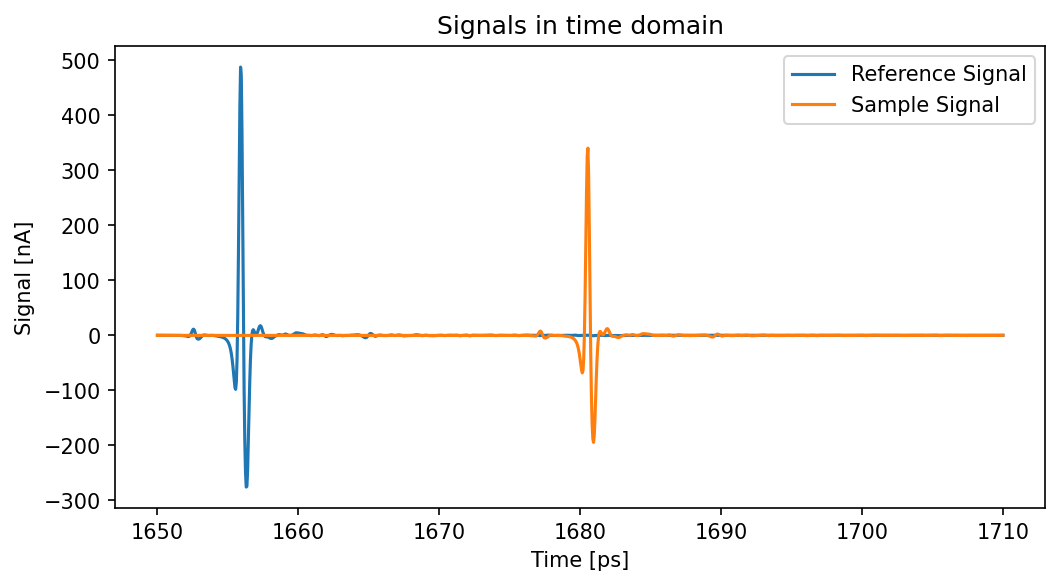

In [6]:
extractor.plot_time_domain()

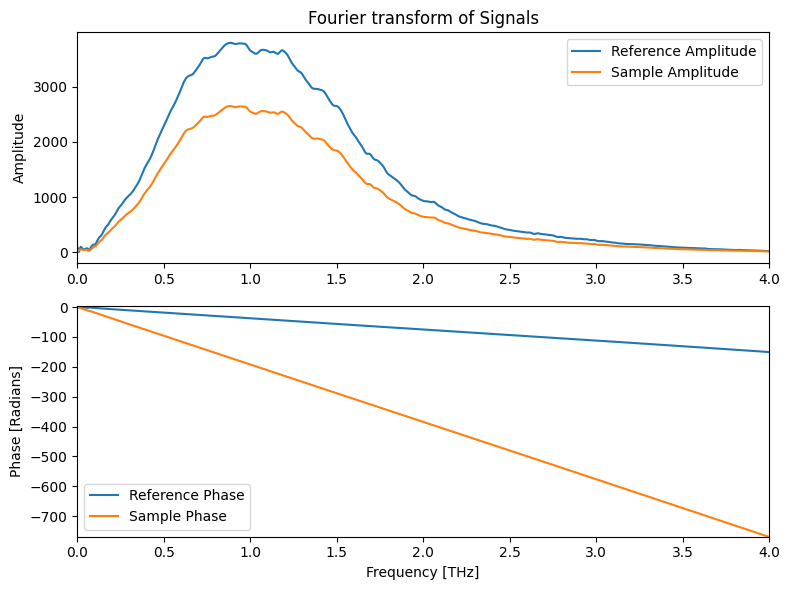

In [7]:
extractor.plot_frequency_domain(x_lims=[0,4])

In [8]:
df = extractor.get_fft_data()
df

,interpolated frequency,amplitude_signal_ref,amplitude_signal_sample,phase_signal_ref,phase_signal_sample,amplitude_transfer,phase_transfer,fast_n
0,0.000000,95.148531,15.572690,-0.429684,2.716322,0.163667,-3.137179,9.405027e+24
1,0.004880,69.694027,23.909452,-1.262713,0.623413,0.343063,-4.397059,1.533071e+01
2,0.009760,6.948951,37.244900,-1.993110,-0.880350,5.359788,-5.170426,9.425614e+00
3,0.014640,60.338845,47.704227,0.215530,-2.192593,0.790606,-2.408124,3.616151e+00
4,0.019520,98.849323,53.157152,-0.549669,-3.419308,0.537759,-2.869639,3.338151e+00
...,...,...,...,...,...,...,...,...
4091,19.963827,94.167196,53.476666,-2179.898373,-5123.353733,0.567891,-2956.021730,3.354959e+00
4092,19.968707,98.849323,53.157152,-2180.575001,-5124.510444,0.537759,-2956.501814,3.354766e+00
4093,19.973587,60.338845,47.704227,-2181.340200,-5125.737159,0.790606,-2956.963329,3.354558e+00
4094,19.978467,6.948951,37.244900,-2179.131560,-5127.049402,5.359788,-2954.201027,3.351784e+00


In [9]:
# Define frequency range we are interested in.
freqs_range = [0.3, 2]

freqs_THz = df['interpolated frequency']

# Find the closest available values within the range
lower_bound = freqs_THz[freqs_THz >= freqs_range[0]].min()
upper_bound = freqs_THz[freqs_THz <= freqs_range[1]].max()

# Apply the boundaries
# Ensure df['frequency'] exists and corresponds to freqs_THz
df_filtered = df[(df['interpolated frequency'] >= lower_bound) & (df['interpolated frequency'] <= upper_bound)]
freqs_THz = freqs_THz[(freqs_THz >= lower_bound) & (freqs_THz <= upper_bound)]

H_values = df_filtered['amplitude_transfer']
phi_values = df_filtered['phase_transfer']

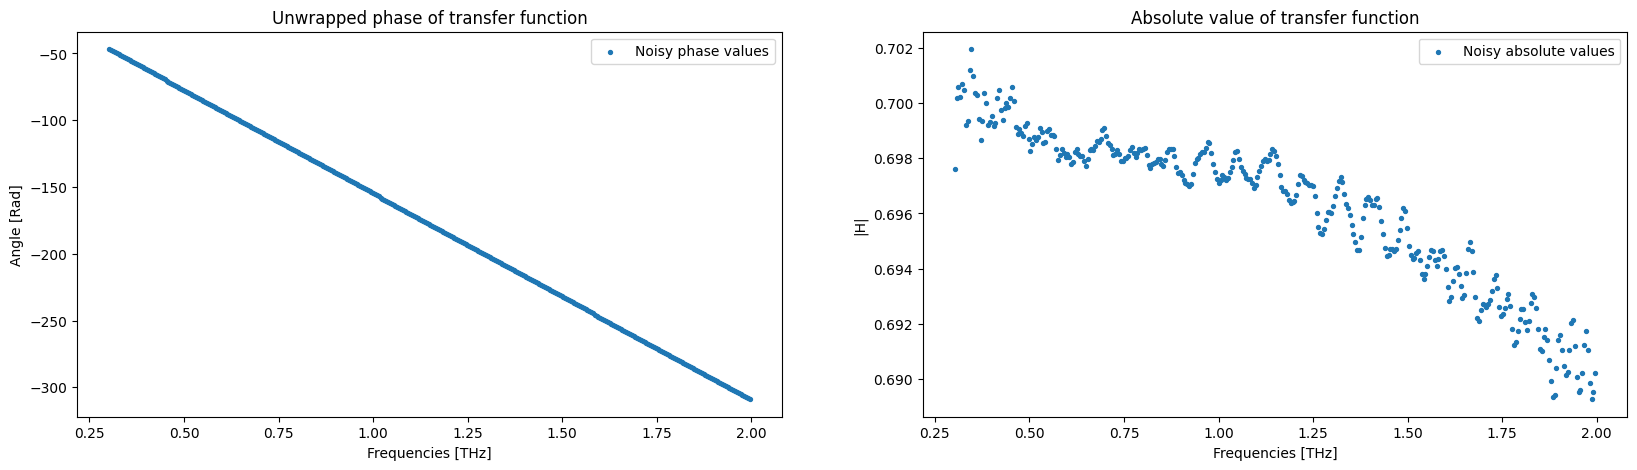

In [10]:
# TODO: alter transfer plot code to match other plots
# TODO: find period of oscillations,c/2nL attribute to physical 
plot_transfer(freqs_THz, H_values, phi_values)

In [11]:
min(freqs_THz), max(freqs_THz)

(0.30255617266469104, 1.9958947519332035)

## Initialize model parameters for ML fitting

Epoch 0: Total Loss = 331.514892578125, Learning Rate = 0.001
Epoch 500: Total Loss = 255.8071746826172, Learning Rate = 0.001
Epoch 1000: Total Loss = 195.4619140625, Learning Rate = 0.001
Epoch 1500: Total Loss = 163.26564025878906, Learning Rate = 0.001
Epoch 2000: Total Loss = 135.68174743652344, Learning Rate = 0.001
Epoch 2500: Total Loss = 105.8876724243164, Learning Rate = 0.001
Epoch 3000: Total Loss = 82.13170623779297, Learning Rate = 0.001
Epoch 3500: Total Loss = 61.8824577331543, Learning Rate = 0.001
Epoch 4000: Total Loss = 55.405426025390625, Learning Rate = 0.001
Epoch 4500: Total Loss = 47.696929931640625, Learning Rate = 0.001
Epoch 5000: Total Loss = 40.871826171875, Learning Rate = 0.001
Epoch 5500: Total Loss = 37.14225387573242, Learning Rate = 0.001
Epoch 6000: Total Loss = 32.770896911621094, Learning Rate = 0.001
Epoch 6500: Total Loss = 29.810710906982422, Learning Rate = 0.001
Epoch 7000: Total Loss = 27.82725715637207, Learning Rate = 0.001
Epoch 7500: Tot

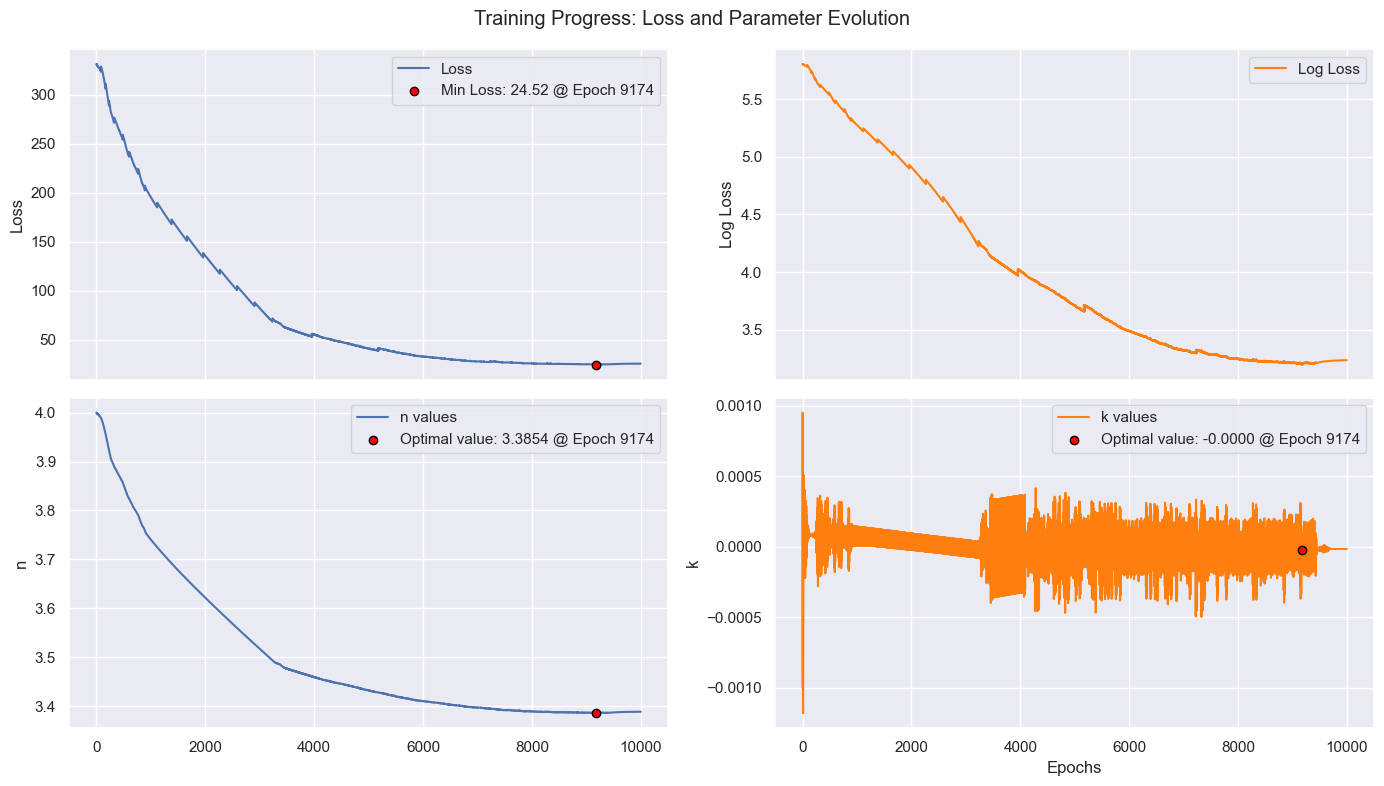

In [12]:
## Use model to fit the experimental data
thickness = 3*1e-3
f = freqs_THz.to_numpy()

# Convert f_tensor to angular freqs with correct scale for predictions
f = f * (1 * 10e12)
w_tensor = f * np.pi * 2

# Convert correct values to tensor
w_tensor = torch.tensor(w_tensor, dtype=torch.float32)
H_values = torch.tensor(H_values.to_numpy(), dtype=torch.float32)
phi_values = torch.tensor(phi_values.to_numpy(), dtype=torch.float32)

# Initialize model for frequency range, thickness and initial conditions
model = TransferFunctionModel(w_tensor=w_tensor,d=thickness, ICs=[4, -0.001])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=250
        )

# Perform optimization
model.train_model(loss_fn=loss, optimizer=optimizer, scheduler=scheduler, H_values=H_values, phi_values=phi_values)

# Access best parameters after training
print(f"Best Parameters: n = {model.best_params['n']}, k = {model.best_params['k']}")

# Plot training curves
model.plot_training_curves()

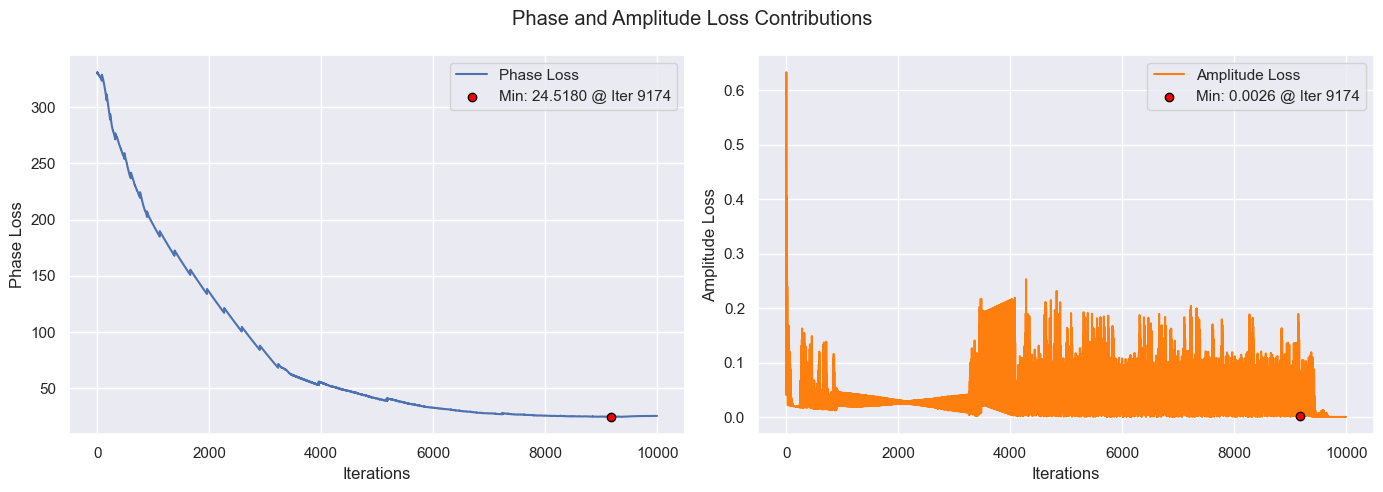

In [13]:
plot_loss_contributions(model.phase_loss_history, model.abs_loss_history)

## Compare reconstructed results with experimental data

In [14]:
optimal_complex_n = model.best_params['n'] + 1j*model.best_params['k']

In [15]:
optimal_H = H_th_function(optimal_complex_n, w=w_tensor, length=3*1e-3)

# Split predictions into components
optimal_abs = torch.abs(optimal_H)
optimal_phase = torch.angle(optimal_H)

# Unwrap phase
optimal_phi = np.unwrap(optimal_phase.numpy())
# Convert back to torch
optimal_phi = torch.tensor(optimal_phi, dtype=torch.float32)

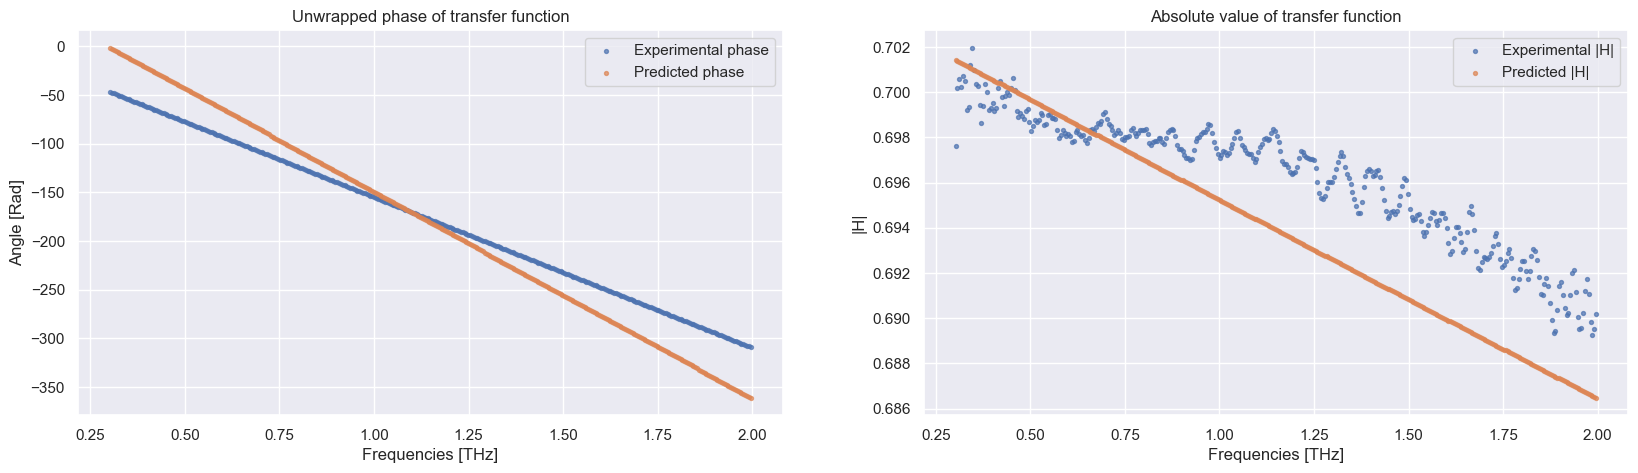

In [16]:
# Plot comparison of experimental data and transfer function with optimized parameters
plot_comparison(freqs_THz, H_values, phi_values, optimal_abs, optimal_phi)

## Compare to reconstruction with analytical solution

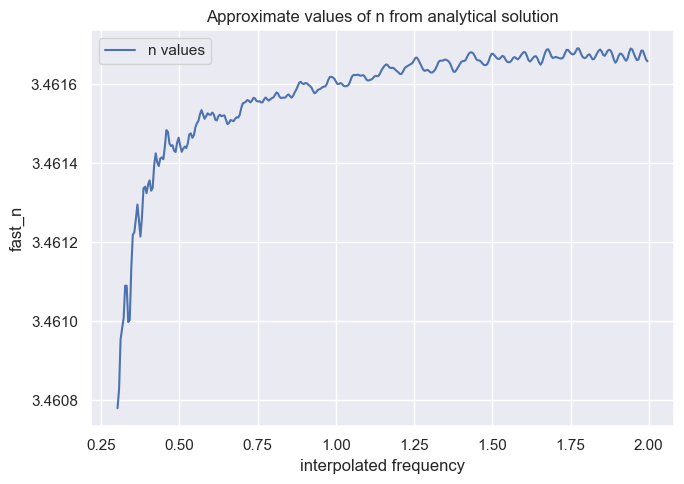

In [31]:
fast_n = df_filtered['fast_n']

plt.figure(figsize=(7,5))
#sns.lineplot(x=freqs_THz, y=fast_n, label="n values")
sns.lineplot(x=freqs_THz, y=fast_n, label="n values")
plt.title('Approximate values of n from analytical solution')
plt.tight_layout()
plt.legend()
plt.show()

In [18]:
fast_n = torch.tensor(fast_n.to_numpy(), dtype=torch.float32)

In [19]:
approx_H = H_th_function(fast_n, w_tensor, thickness)

# Split predictions into components
approx_abs = torch.abs(approx_H)
approx_phase = torch.angle(approx_H)

# Unwrap phase
approx_phi = np.unwrap(approx_phase.numpy())
# Convert back to torch
approx_phi = torch.tensor(approx_phi, dtype=torch.float32)

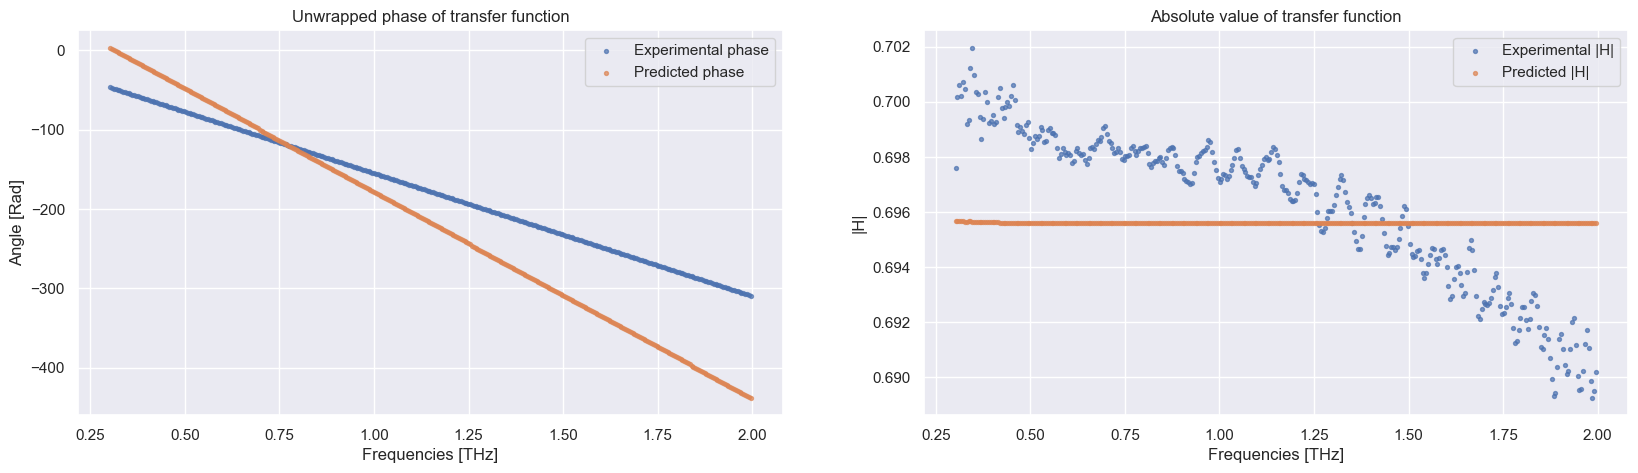

In [20]:
plot_comparison(freqs_THz, H_values, phi_values, approx_abs, approx_phi)

In [21]:
#export = df_filtered[['fast_n','interpolated frequency']]
#export.to_csv('fast_n_si.csv', index=False)

## Reconstructing with the N-R Extraction

In [22]:
NR = pd.read_csv('NR-optimised_values.csv')
# Truncate frequencies 
NR = NR[NR['frequencies'] <= 2]

NR_freqs = torch.tensor(NR['frequencies'].to_numpy(),  dtype=torch.float32)
NR_freqs = NR_freqs * 1e12 * 2 * np.pi

# Ensure the column is a NumPy complex array
n_NR_np = np.array(NR['n_NR'], dtype=np.complex128)

# Convert to a PyTorch complex tensor
n_NR = torch.tensor(n_NR_np, dtype=torch.cfloat)

NR_H = H_th_function(n_NR, NR_freqs, thickness)

In [23]:
abs_NR_H = torch.abs(NR_H)
phi_NR = np.unwrap(np.angle(NR_H))

# Add transfer function values to dataframe
NR['abs_NR_H'] = abs_NR_H
NR['phi_NR'] = phi_NR
NR['n'] = torch.real(n_NR)
NR['k'] = torch.imag(n_NR)

NR_extended = NR

# Truncate NR for optimal plotting
NR = NR[NR['frequencies'] >= 0.3]

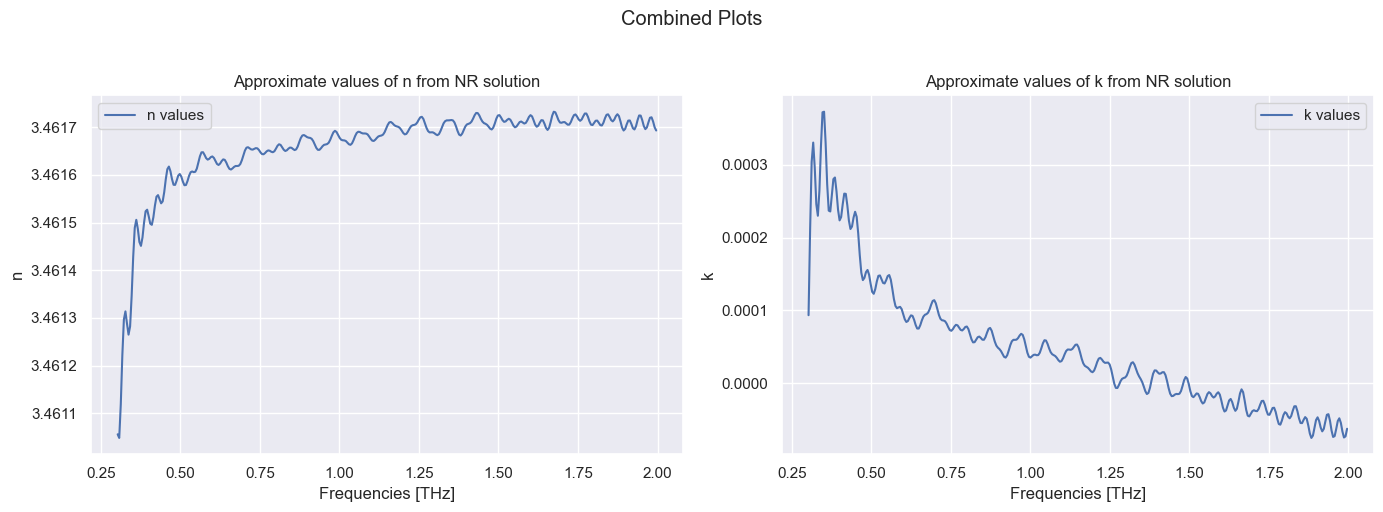

In [32]:
# Create the first subplot (assuming 'data1' is your first dataset)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Approximate values of n from NR solution
sns.lineplot(x=NR['frequencies'], y=NR['n'], label="n values", ax=ax1)
ax1.set_title('Approximate values of n from NR solution')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.set_xlabel('Frequencies [THz]')

# Second plot (assuming 'data2' is your second dataset with x and y values)
sns.lineplot(x=NR['frequencies'], y=NR['k'], label="k values", ax=ax2)
ax2.set_title('Approximate values of k from NR solution')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax2.set_xlabel('Frequencies [THz]')

# Adjust layout and add main title if needed
plt.suptitle('Combined Plots', y=1.02)
plt.tight_layout()
plt.legend()
plt.show()

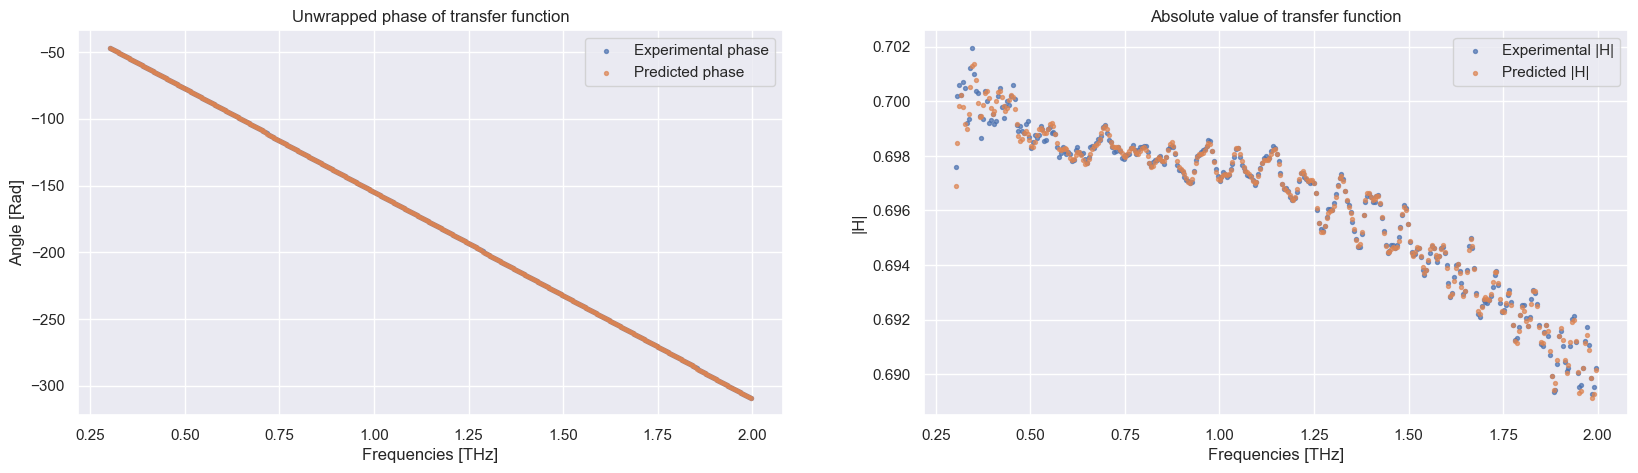

In [25]:
plot_comparison(NR['frequencies'], H_values, phi_values, NR['abs_NR_H'], NR['phi_NR'])
#plot_transfer(NR['frequencies'], NR['abs_NR_H'],  NR['phi_NR'])

## Compare analytical n with NR n

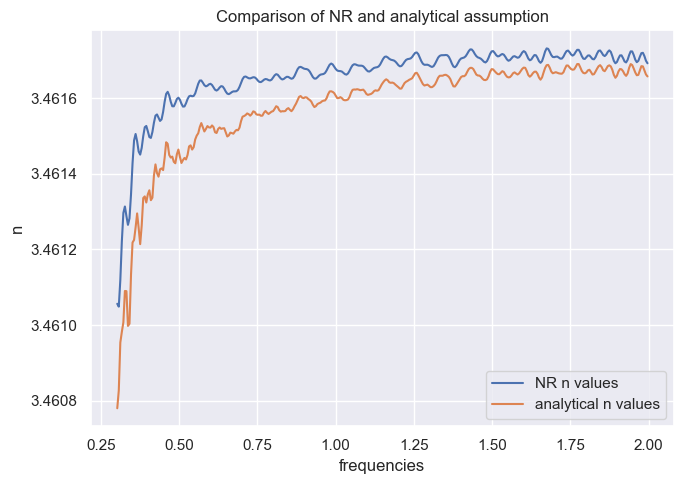

In [26]:
plt.figure(figsize=(7,5))
sns.lineplot(x=NR['frequencies'], y=NR['n'], label="NR n values")
sns.lineplot(x=freqs_THz, y=fast_n, label="analytical n values")
plt.title('Comparison of NR and analytical assumption')

# Ensure the y-axis shows absolute values without offset notation
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

plt.tight_layout()
plt.legend()
plt.show()

## What happens if you negate k in the NR n values

In [27]:
# Make predictions across full frequency range.


NR_H_from_real = H_th_function(torch.real(n_NR), NR_freqs, thickness)

abs_NR_H_from_real = torch.abs(NR_H_from_real)
phi_NR_from_real = np.unwrap(np.angle(NR_H_from_real))

NR_only_real = pd.DataFrame()
NR_only_real['frequencies'] = NR_extended['frequencies']
NR_only_real['n'] =NR_extended['n']
NR_only_real['abs'] = abs_NR_H_from_real
NR_only_real['phi'] = phi_NR_from_real

filter = NR_only_real['frequencies'] >= 0.3

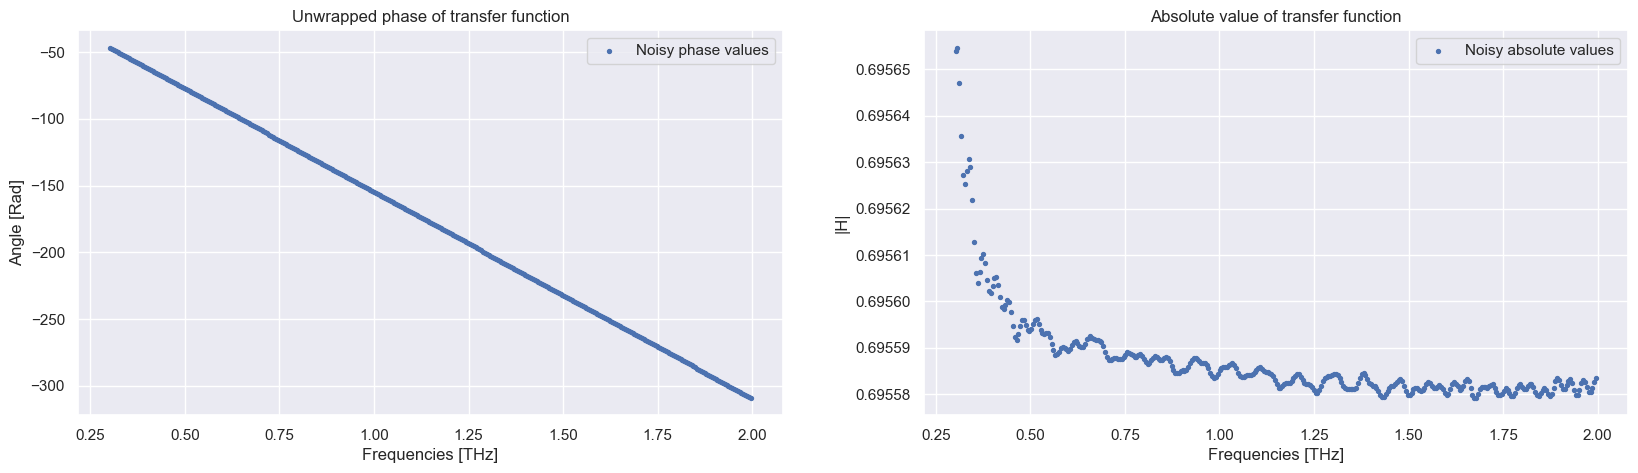

In [29]:
plot_transfer(NR_only_real['frequencies'][filter], NR_only_real['abs'][filter], NR_only_real['phi'][filter])

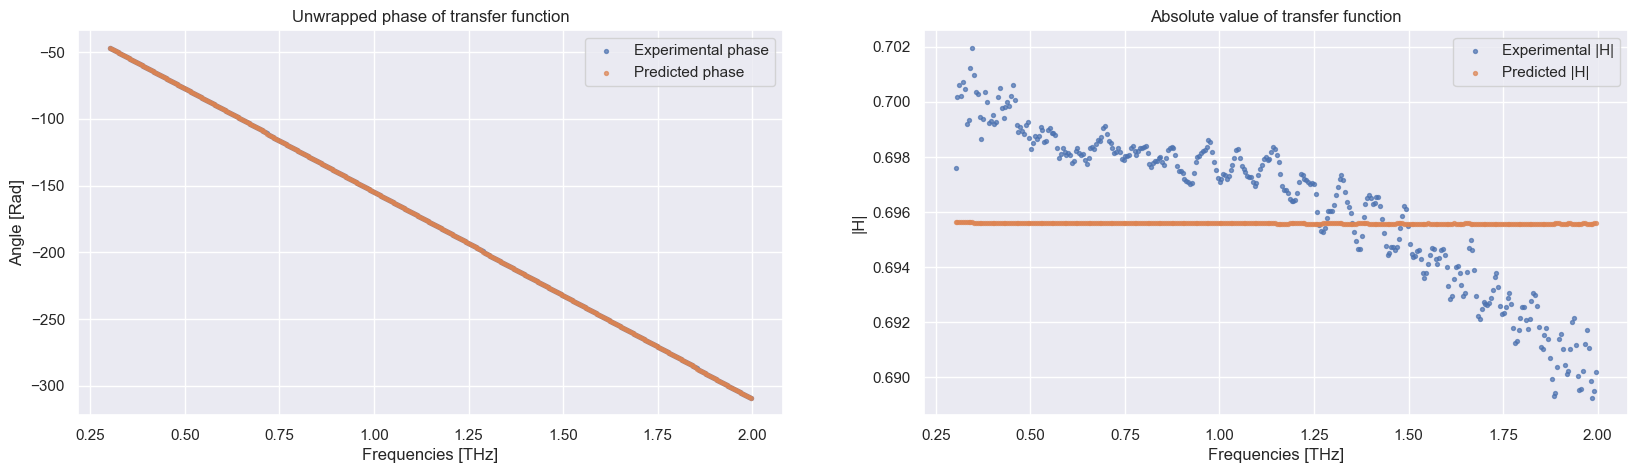

In [30]:
plot_comparison(NR['frequencies'], H_values, phi_values, NR_only_real['abs'][filter], NR_only_real['phi'][filter])